# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Задача:**

- Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
- Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
- Необходимо построить модель с предельно большим значением *F1*-меры. Пороговое значение метрики - 0.59.
- Дополнительно нужно измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.


**Признаки:**
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак:**

* `Exited` — факт ухода клиента

**Краткий план действий:**

1. Загрузка и изучение данных.
2. Предобработка данных.
3. Исследование задачи: необходимо проанализировать баланс классов и обучить модели с фактическим балансом классов.
4. Улучшить модели, учитывая проблему дисбаланса классов. Выявить лучшую модель.
5. Провести финальное тестирование моделей.

## Загрузка и осмотр данных

In [ ]:
# загружаем необходимые библиотеки и модули
!pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# загрузим данные
data = pd.read_csv('/datasets/Churn.csv')

In [ ]:
# изучим данные
display(data.sample(10))
display(data.info(),data.describe())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9989,9990,15605622,McMillan,841,Spain,Male,28,4.0,0.00,2,1,1,179436.60,0
6060,6061,15669253,Gibson,754,Spain,Male,39,7.0,157691.98,2,1,0,133600.89,1
8122,8123,15603749,Galkina,564,France,Female,53,2.0,45472.28,1,1,1,41055.71,1
3609,3610,15657868,Serra,850,Germany,Male,40,6.0,94607.08,1,1,0,36690.49,0
4533,4534,15607275,Ch'ang,850,Spain,Male,39,NaN,206014.94,2,0,1,42774.84,1
4127,4128,15625545,Hussey,712,Spain,Male,52,9.0,0.00,1,1,1,117977.45,1
2925,2926,15633531,Lavrov,717,France,Female,76,9.0,138489.66,1,1,1,68400.14,0
2581,2582,15634719,Chinwendu,704,France,Male,31,NaN,0.00,2,1,0,183038.33,0
7057,7058,15684512,Gibson,818,Germany,Female,72,8.0,135290.42,2,1,1,63729.72,0
3219,3220,15611191,Scott,505,Germany,Female,37,10.0,122453.97,2,1,1,52693.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


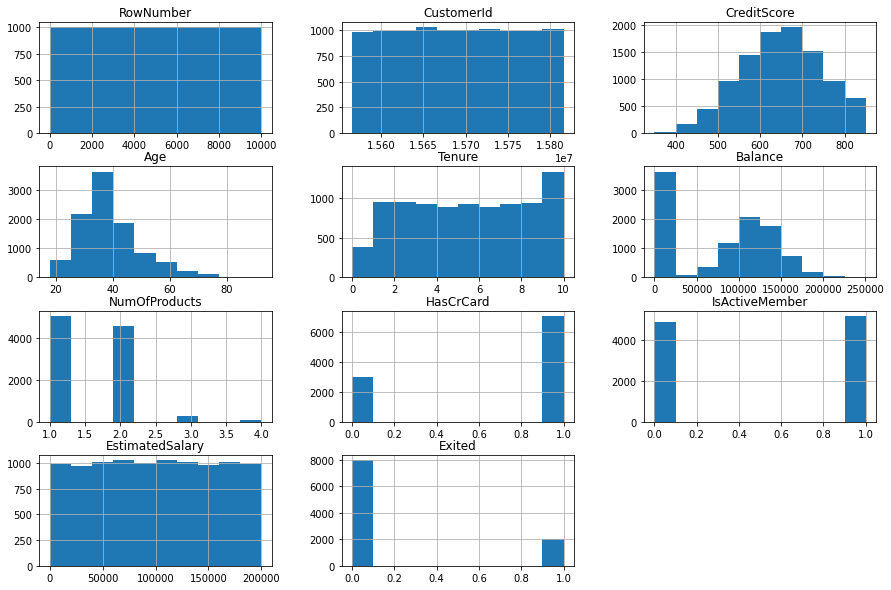

In [ ]:
# построим гистограммы для столбцов в датасете
data.hist(figsize = (15,10));

In [ ]:
# выведем количество пропусков в столбце Tenure
print('Доля пропусков,%:',(data['Tenure'].isna().sum() / len(data))*100)

Доля пропусков,%: 9.09


In [ ]:
display(data[data['Tenure'].isna()])

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


На первый взгляд никаких закономерностей между пропусками и остальными данными не прослеживается.

In [ ]:
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Корреляция признака `Tenure` с остальными признаками отсутствует.

Возможно, пропуски есть у клиентов, которые пользуются услугами банка меньше года. Посмотрим на значения в столбце `Tenure`:

In [ ]:
data['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

У некоторых людей в данном признаке стоит 0, что оговорит о том, что срок до года также учитывается при формировании данных. В таком случае замена NaN на 0 не выглядит наилучшим способом заполнения пропусков.

Посмотрим, как распределены данные:

Среднее значение столбца Tenure: 4.997690023099769
Медианное значение столбца Tenure: 5.0


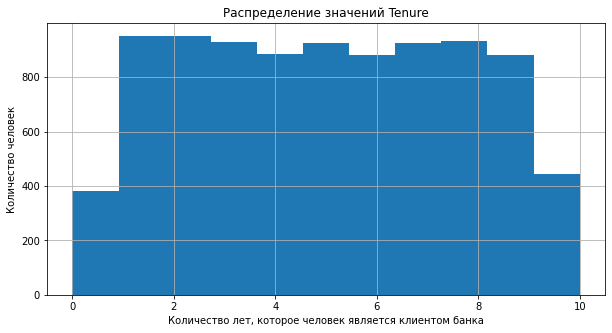

In [ ]:
print('Среднее значение столбца Tenure:', data['Tenure'].mean())
print('Медианное значение столбца Tenure:', data['Tenure'].median())

# построим гистограмму
data['Tenure'].hist(figsize=(10,5), bins = 11)
plt.title('Распределение значений Tenure')
plt.xlabel('Количество лет, которое человек является клиентом банка')
plt.ylabel('Количество человек');

Распределение похоже на равномерное, поэтому заполнение пропусков средним, медианным значением или модой исказит данные и скорее всего приведет к ухудшению предсказаний моделей. В случае нормального распределения можно было бы рассмотреть этот вариант заполнения пропусков.

Удаление строк с пропущенными значениям также является плохим вариантом. В таком случае мы теряем практически 10% данных, что близко к критическому уровню потерь.

Попробуем восстановить пропущенные значения с помощью алгоритма **Sklearn KNNImputer** после разделения датасета на обучающую, валидационную и тренировочную выборки, чтобы избежать утечки данных.

### Вывод

Для создания и обучения моделей машинного обучения нам необходимо подготовить признаки:

- в датасете присутствуют столбцы, которые не нужны для построения моделей: `RowNumber`, `CustomerId` и `Surname`;
- категориальные признаки `Geography` и	`Gender` необходимо перевести в численные;
- данные необходимо стандартизировать, так как признаки имеют разный масштаб;
- имеется пропуски в столбце `Tenure`.

## Подготовка данных

### Избавимся от ненужных столбцов

Столбцы `RowNumber`,`CustomerId` и `Surname` имеют уникальные значения, которые не содержат полезной информации для классификации. Удалим их:

In [ ]:
df = data.drop(['RowNumber','CustomerId','Surname'], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Проверка на явные дубликаты

In [ ]:
df.duplicated().sum()

0

Явных дубликатов нет.

### Разделим данные на обучающую, валидационную  и тестовую выборки

Выделим предикторы и целевой признак из нашего датасета

In [ ]:
features = df.drop(['Exited'], axis = 1)
target = df['Exited']

Разделим наши данные сначала на 2 выборки в соотношении 60/40. 60% данных оставим для тренировочной выборки, 40% данных - для валидационной и тестовой выборок:

In [ ]:
features_train, features_remains, target_train, target_remains = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.4,
                                                                                  random_state=12345)

Разделим оставшиеся 40% данных на валидационную и тестовую выборки в соотношении 50/50:

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(features_remains,
                                                                            target_remains,
                                                                            test_size=0.5,
                                                                            random_state=12345)

Проверим количество распределенных данных в выборках:

In [ ]:
display(target_train.shape, target_valid.shape, target_test.shape)
display(features_train.shape, features_valid.shape, features_test.shape)

(6000,)

(2000,)

(2000,)

(6000, 10)

(2000, 10)

(2000, 10)

### Перевод категориальных признаков в численные

Выведем на экран значения категориальных признаков:

In [ ]:
display(df['Geography'].value_counts(),df['Gender'].value_counts())

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Male      5457
Female    4543
Name: Gender, dtype: int64

Категориальные признаки `Geography` и `Gender` переведем в численные техникой прямого кодирования (OHE). Используем библиотеку **category encoders** для кодирования признаков. Чтобы избежать dummy-ловушки, удалим по одному получившемуся стобцу класса каждого преобразуемого признака:

In [ ]:
# в параметр cols передадим столбцы, которые нужно преобразовать
ohe_encoder = ce.OneHotEncoder(cols = ['Geography','Gender'])

# обучим encoder на тестовой выборке
ohe_encoder = ohe_encoder.fit(features_train)

# применим кодирование к выборкам
features_train = ohe_encoder.transform(features_train).drop(['Geography_3','Gender_2'], axis =1)
features_valid = ohe_encoder.transform(features_valid).drop(['Geography_3','Gender_2'], axis =1)
features_test = ohe_encoder.transform(features_test).drop(['Geography_3','Gender_2'], axis =1)

In [ ]:
display(features_valid)

,CreditScore,Geography_1,Geography_2,Gender_1,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8532,585,0,1,0,35,2.0,0.00,2,1,0,98621.04
5799,625,0,1,0,45,3.0,0.00,1,1,1,184474.15
5511,667,0,0,1,32,0.0,103846.65,1,1,0,20560.69
7365,568,1,0,0,36,10.0,153610.61,1,1,1,54083.80
7367,606,1,0,1,42,10.0,0.00,2,1,0,177938.52
...,...,...,...,...,...,...,...,...,...,...,...
6480,679,0,1,0,24,6.0,114948.76,2,0,1,135768.25
8194,632,0,1,1,42,4.0,126115.60,1,1,0,100998.50
1279,521,0,1,0,39,6.0,0.00,2,0,1,27375.15
6532,756,0,1,1,67,4.0,0.00,3,1,1,93081.87


### Стандартизация данных

Cтандартизируем столбцы с разным масштабом с помощью **StandardScaler**:

In [ ]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()

# настроим (вычислим среднее и дисперсию)
scaler.fit(features_train[numeric])

# преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head(5)

,CreditScore,Geography_1,Geography_2,Gender_1,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,-0.886751,1,0,1,-0.373192,1.030263,1.232271,-0.891560,1,0,-0.187705
3411,0.608663,0,1,0,-0.183385,1.030263,0.600563,-0.891560,0,0,-0.333945
6027,2.052152,0,0,1,0.480939,-0.703821,1.027098,0.830152,0,1,1.503095
1247,-1.457915,0,1,1,-1.417129,0.336629,-1.233163,0.830152,1,0,-1.071061
3716,0.130961,0,0,0,-1.132419,-1.050638,1.140475,-0.891560,0,0,1.524268


### Обработка пропусков

Восстановим пропущенные значения с помощью алгоритма **Sklearn KNNImputer**:

In [ ]:
# создадим объект класса KNNImputer с параметрами:
# пять соседей и однаковым весом каждого из них

knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')

# обучим алгоритм на обучающей выборке
knn_imputer.fit(features_train)

# восстанавливаем данные в обучающей выборке
features_train_knn = pd.DataFrame(knn_imputer.transform(features_train),columns = features_train.columns)

Проверим получившееся распределение:

Количество оставшихся пропусков в обучающей выборке: 0



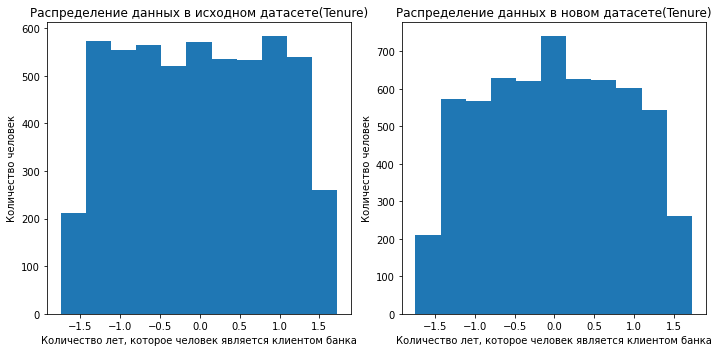

In [ ]:
# проверим наличие пропусков
print("Количество оставшихся пропусков в обучающей выборке:", features_train_knn['Tenure'].isna().sum())
print('')

# визуализируем распределения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


features_train['Tenure'].plot(kind='hist',
                              ax = ax1,
                              bins = 11)
ax1.set_title('Распределение данных в исходном датасете(Tenure)')
ax1.set_xlabel('Количество лет, которое человек является клиентом банка')
ax1.set_ylabel('Количество человек')


features_train_knn['Tenure'].plot(kind='hist',
                                  ax = ax2,
                                  bins = 11)
ax2.set_title('Распределение данных в новом датасете(Tenure)')
ax2.set_xlabel('Количество лет, которое человек является клиентом банка')
ax2.set_ylabel('Количество человек')

plt.tight_layout()
plt.show()

На гистограмме видно, что значения распределились достаточно равномерно, пик не настолько выражен, как если бы пропуски заполнили медианой, средним или модой.

Используем обученный алгоритм, для заполнения пропусков в валидационной и тестовой выборках:

In [ ]:
features_train = features_train_knn
features_valid = pd.DataFrame(knn_imputer.transform(features_valid),columns = features_valid.columns)
features_test = pd.DataFrame(knn_imputer.transform(features_test),columns = features_test.columns)

In [ ]:
print("Количество оставшихся пропусков в валидационной выборке:", features_valid['Tenure'].isna().sum())
print("Количество оставшихся пропусков в тестовой выборке:", features_test['Tenure'].isna().sum())

Количество оставшихся пропусков в валидационной выборке: 0
Количество оставшихся пропусков в тестовой выборке: 0


**NB!** В любом случае необходимо также оформить баг-репорт для коллег, указав, что при формировании или выгрузке данных происходит ошибка.

In [ ]:
# сбросим индексы в целевом признаке каждой выборки
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

## Исследование задачи

Построим барплот баланса классов в целевом признаке:

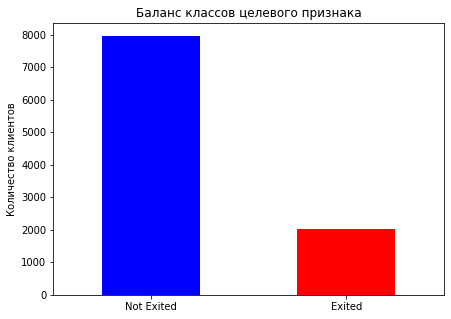

In [ ]:
colors = ['blue', 'red']
df['Exited'].value_counts().plot(kind='bar', figsize=(7, 5), color=colors)
plt.ylabel('Количество клиентов')
plt.title('Баланс классов целевого признака')
plt.xticks([0, 1], ['Not Exited', 'Exited'], rotation = 0)
plt.show()

### Обучим модели  без учета дисбаланса

In [ ]:
# создадим таблицу для сравнения f1-метрики
models = [
    {"name": "Decision Tree", "model": DecisionTreeClassifier(random_state=12345)},
    {"name": "Random Forest", "model": RandomForestClassifier(random_state=12345)},
    {"name": "Logistic Regression", "model": LogisticRegression(random_state=12345)}

]

results = []

for model_info in models:
    model = model_info["model"]
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    imbalance_f1 = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    imbalance_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    results.append({"Model": model_info["name"], "F1_imbalance": imbalance_f1,
                                                 "ROC-AUC_imbalance": imbalance_auc_roc})


class_balance = pd.DataFrame(results)

display(class_balance)

,Model,F1_imbalance,ROC-AUC_imbalance
0,Decision Tree,0.448687,0.651555
1,Random Forest,0.564103,0.839755
2,Logistic Regression,0.331641,0.758626


Лучше всего с несбалансированными классами справился случайный лес. Однако значение f1-метрики не достигло порогового. Хуже всего с прогнозированием справилась логистическая регрессия, однако, значение ROC-AUC у нее выше, чем у дерева решений.

## Борьба с дисбалансом

### Метод 1: class_weight = ‘balanced’

Попробуем восстановить баланс классов с помощью гиперпараметра `class_weight`. Лучшие значения f1-метрики будем сохранять в переменных, а затем добавим их в сравнительную таблицу.

In [ ]:
# обучим модель дерева решений с гиперпараметром class_weight = 'balanced'

model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
tree_balance = f1_score(target_valid, predictions)

print("F1-метрика модели DecisionTreeClassifier (class_weight = 'balanced'):", tree_balance)


F1-метрика модели DecisionTreeClassifier (class_weight = 'balanced'): 0.48410757946210264


In [ ]:
# обучим модель случайного леса с гиперпараметром class_weight = 'balanced'

model = RandomForestClassifier(random_state=12345, class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
forest_balance = f1_score(target_valid, predicted_valid)

print("F1-метрика модели RandomForestClassifier(class_weight = 'balanced'):", forest_balance,)

F1-метрика модели RandomForestClassifier(class_weight = 'balanced'): 0.5510835913312693


In [ ]:
# обучим модель логистической регрессии с гиперпараметром class_weight = 'balanced'

model = LogisticRegression(random_state=12345, class_weight = 'balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
log_reg_balance = f1_score(target_valid, predicted_valid)

print("F1-метрика модели LogisticRegression (class_weight = 'balanced'):", log_reg_balance)

F1-метрика модели LogisticRegression (class_weight = 'balanced'): 0.48843187660668386


In [ ]:
class_balance = class_balance.assign(F1_class_weight_balanced =[tree_balance,
                                                                forest_balance,
                                                                log_reg_balance])
display(class_balance)

,Model,F1_imbalance,ROC-AUC_imbalance,F1_class_weight_balanced
0,Decision Tree,0.448687,0.651555,0.484108
1,Random Forest,0.564103,0.839755,0.551084
2,Logistic Regression,0.331641,0.758626,0.488432


Значения f1-метрики у дерева решений и логистической регрессии увеличились и стали приктически равными, а вот среднее гармоническое точности и полноты случайного леса уменьшилось, но незначительно ~ на 0.01. Порогового показателя не достигла ни одна модель.

### Метод 2: Увеличение выборки (upsampling)

Попробуем выровнять баланс классов, увеличив долю положительного в 4 раза:

In [ ]:
# напишем функцию upsample для увеличения положительного класса в 4 раза
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # соединим таблицы, продублировав объекты положительного класса
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешаем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

# применим функцию
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# проверим новый объем данных
print(features_upsampled.shape, target_upsampled.shape)
print('')

# посмотрим на новое распределние классов
print('Распределение классов после upsampling:')
print(target_upsampled.value_counts())

(9588, 11) (9588,)

Распределение классов после upsampling:
0    4804
1    4784
Name: Exited, dtype: int64


Баланс классов выровнялся, протестируем обучение моделей на новой выборке:

In [ ]:
# обучим модель дерева решений на выборке с измененным балансом целевого признака

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
tree_upsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика DecisionTreeClassifier с upsampling:",tree_upsampled)

F1-метрика DecisionTreeClassifier с upsampling: 0.4884004884004884


In [ ]:
# обучим модель случайного леса на выборке с измененным балансом целевого признака

model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
forest_upsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика RandomForestClassifier с upsampling:", forest_upsampled)

F1-метрика RandomForestClassifier с upsampling: 0.5956873315363881


In [ ]:
# обучим модель логистической регрессии с измененным балансом целевого признака

model = LogisticRegression(random_state=12345,)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
log_reg_upsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика LogisticRegression с upsampling:", log_reg_upsampled)

F1-метрика LogisticRegression с upsampling: 0.48843187660668386


In [ ]:
# добавим новые показатели f1-метрики в сравнительную таблицу
class_balance = class_balance.assign(F1_upsampling =[tree_upsampled, forest_upsampled, log_reg_upsampled])
display(class_balance)

,Model,F1_imbalance,ROC-AUC_imbalance,F1_class_weight_balanced,F1_upsampling
0,Decision Tree,0.448687,0.651555,0.484108,0.488400
1,Random Forest,0.564103,0.839755,0.551084,0.595687
2,Logistic Regression,0.331641,0.758626,0.488432,0.488432


Значение f1-метрики дерева решений после upsampling изменилось незначительно, для логистической регрессии показатель метрики остался прежним, а модель случайного леса минимально превысила требуемый порог.

### Метод 3: Уменьшение выборки (downsampling)

In [ ]:
# напишем функцию downsample для уменьшения отрицательного класса в 4 раза
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

# применим функцию к тренировочной выборке
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

# проверим новый объем данных
print(features_downsampled.shape, target_downsampled.shape)
print('')

# посмотрим на новое распределние классов
print('Распределение классов после downsampling:')
print(target_downsampled.value_counts())

(2637, 11) (2637,)

Распределение классов после downsampling:
0    1441
1    1196
Name: Exited, dtype: int64


In [ ]:
# обучим модель дерева решений на выборке с измененным балансом целевого признака

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
tree_downsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика DecisionTreeClassifier с downsampling:",tree_downsampled)

F1-метрика DecisionTreeClassifier с downsampling: 0.500422654268808


In [ ]:
# обучим модель случайного леса на выборке с измененным балансом целевого признака

model = RandomForestClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
forest_downsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика RandomForestClassifier с downsampling:", forest_downsampled)

F1-метрика RandomForestClassifier с downsampling: 0.593186372745491


In [ ]:
# обучим модель логистической регрессии на выборке с измененным балансом целевого признака

model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
log_reg_downsampled = f1_score(target_valid, predicted_valid)

print("F1-метрика LogisticRegression с downsampling:", log_reg_downsampled)

F1-метрика LogisticRegression с downsampling: 0.49574266792809846


In [ ]:
# добавим новые показатели f1-метрики в сравнительную таблицу
class_balance = class_balance.assign(F1_downsampling =[tree_downsampled,
                                                       forest_downsampled,
                                                       log_reg_downsampled])
display(class_balance)

,Model,F1_imbalance,ROC-AUC_imbalance,F1_class_weight_balanced,F1_upsampling,F1_downsampling
0,Decision Tree,0.448687,0.651555,0.484108,0.488400,0.500423
1,Random Forest,0.564103,0.839755,0.551084,0.595687,0.593186
2,Logistic Regression,0.331641,0.758626,0.488432,0.488432,0.495743


Значения f1-метрики дерева решений и логистической регрессии выросли, но все еще не достигли порогового значения, метрика случайного леса изменилась незначительно по сравнению с upsampling.

### Метод 4: Изменение порога

Для логистической регрессии и случайного леса изменим порог классификации и посмотрим, какими станут метрики:

In [ ]:
# обучим модель логистической регрессии
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# с помощью цикла переберем пороги классификации и сравним метрики
for threshold in np.arange(0, 0.9, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.05 | Точность = 0.235, Полнота = 0.981, F1 = 0.379
Порог = 0.10 | Точность = 0.277, Полнота = 0.897, F1 = 0.423
Порог = 0.15 | Точность = 0.326, Полнота = 0.789, F1 = 0.462
Порог = 0.20 | Точность = 0.369, Полнота = 0.672, F1 = 0.477
Порог = 0.25 | Точность = 0.424, Полнота = 0.600, F1 = 0.497
Порог = 0.30 | Точность = 0.455, Полнота = 0.517, F1 = 0.484
Порог = 0.35 | Точность = 0.486, Полнота = 0.426, F1 = 0.454
Порог = 0.40 | Точность = 0.502, Полнота = 0.330, F1 = 0.398
Порог = 0.45 | Точность = 0.524, Полнота = 0.282, F1 = 0.367
Порог = 0.50 | Точность = 0.566, Полнота = 0.234, F1 = 0.332
Порог = 0.55 | Точность = 0.621, Полнота = 0.172, F1 = 0.270
Порог = 0.60 | Точность = 0.654, Полнота = 0.122, F1 = 0.206
Порог = 0.65 | Точность = 0.647, Полнота = 0.079, F1 = 0.141
Порог = 0.70 | Точность = 0.633, Полнота = 0.045, F1 = 0.085
Порог = 0.75 | Точность = 0.650, Полнота = 0.031, F1 = 0.059
Порог = 0.80 | Точность 

Лучшее значение f1-метрики для логистической регрессии наблюдается при пороге равном 0.25. Однако оно все еще не достигает минимально требуемого значения.

In [ ]:
# обучим модель случайного леса
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# с помощью цикла переберем пороги классификации и сравним метрики
for threshold in np.arange(0, 0.9, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.220, Полнота = 0.993, F1 = 0.360
Порог = 0.05 | Точность = 0.279, Полнота = 0.935, F1 = 0.430
Порог = 0.10 | Точность = 0.340, Полнота = 0.885, F1 = 0.492
Порог = 0.15 | Точность = 0.396, Полнота = 0.823, F1 = 0.535
Порог = 0.20 | Точность = 0.450, Полнота = 0.758, F1 = 0.565
Порог = 0.25 | Точность = 0.504, Полнота = 0.699, F1 = 0.586
Порог = 0.30 | Точность = 0.568, Полнота = 0.646, F1 = 0.605
Порог = 0.35 | Точность = 0.624, Полнота = 0.589, F1 = 0.606
Порог = 0.40 | Точность = 0.664, Полнота = 0.538, F1 = 0.594
Порог = 0.45 | Точность = 0.717, Полнота = 0.490, F1 = 0.582
Порог = 0.50 | Точность = 0.763, Полнота = 0.447, F1 = 0.564
Порог = 0.55 | Точность = 0.809, Полнота = 0.416, F1 = 0.550
Порог = 0.60 | Точность = 0.854, Полнота = 0.392, F1 = 0.538
Порог = 0.65 | Точность = 0.880, Полнота = 0.352, F1 = 0.503
Порог = 0.70 | Точность = 0.896, Полнота = 0.289, F1 = 0.438
Порог = 0.75 | Точность = 0.899, Полнота = 0.234, F1 = 0.372
Порог = 0.80 | Точность 

Наиболее высокий показатель f1-метрики для случайного леса наблюдается при пороге 0.35.

## Выбор лучшей модели

Лучшие показатели f1-метрики мы получили у моделей случайного леса:
    
- class_weight = ‘balanced’: **0.551084**
- upsampling: **0.595687**
- downsampling: **0.593186**

Чтобы выбрать лучшую модель для финального тестирования, воспользуемся метрикой AUC-ROC (определим, насколько хорошо наши модели разделяют два класса). Дополнительно для каждой модели выведем матрицу ошибок:

### Модель № 1

In [ ]:
model = RandomForestClassifier(random_state=12345,
                               class_weight = 'balanced')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("RandomForestClassifier (class_weight = 'balanced'):")
print('')
print("AUC-ROC =", auc_roc)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid,predicted_valid))

RandomForestClassifier (class_weight = 'balanced'):

AUC-ROC = 0.8375103587609409

Матрица ошибок:
[[1532   50]
 [ 240  178]]


### Модель № 2

In [ ]:
model = RandomForestClassifier(random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("RandomForestClassifier (upsampling):")
print('')
print("AUC-ROC =", auc_roc)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid,predicted_valid))

RandomForestClassifier (upsampling):

AUC-ROC = 0.8349713281594977

Матрица ошибок:
[[1479  103]
 [ 197  221]]


### Модель № 3

In [ ]:
model = RandomForestClassifier(random_state=12345)

model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


print("RandomForestClassifier (downsampling):")
print('')
print("AUC-ROC =", auc_roc)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid,predicted_valid))

RandomForestClassifier (downsampling):

AUC-ROC = 0.8398044084467

Матрица ошибок:
[[1298  284]
 [ 122  296]]


Показатели AUC-ROC метрики у моделей практически равны. Если смотреть на матрицы ошибок, то на первый взгляд кажется, что лучшая модель - модель с downsampling. Доля истинно положительных ответов у нее самая высокая, а ложноотрицательных самая низкая. Однако она чаще других выдает ложноположительные ответы (в 5 раз больше 1-ой модели и в 2,8 раза больше 2-ой). Первая модель хуже остальных предсказывает положительный класс. В таком случае наиболее сбалансированная модель - **вторая**. Она неплохо предсказывает положительный класс (TP-ответов достаточно, а FP-ответов меньше чем у третьей модели)

### Подбор оптимальных параметров

Подберем оптимальные параметры для выбранной модели с помощью **GridSearch**:

In [ ]:
model = RandomForestClassifier()

# сетка параметров
parameters = {'n_estimators': range (100,350,50),
              'max_depth': range (1,16,2),
             }


grid_search = GridSearchCV(model, parameters, scoring='f1', cv=None)
grid_search.fit(features_upsampled, target_upsampled)

# получение оптимальных параметров
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 300}

## Тестирование модели

In [ ]:
model = RandomForestClassifier(random_state = 12345,
                               n_estimators = 300,
                               max_depth = 15)

model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("F1-метрика RandomForestClassifier на тестовой выборке:", result)
print("AUC-ROC RandomForestClassifier на тестовой выборке:", auc_roc)

F1-метрика RandomForestClassifier на тестовой выборке: 0.6012738853503184
AUC-ROC RandomForestClassifier на тестовой выборке: 0.849407334451655


Значение f1-метрики случайного леса с подобранными параметрами на тестовой выборке равно ~ 0.60, что выше порогового на 0,01.

Построим график важности признаков для модели:

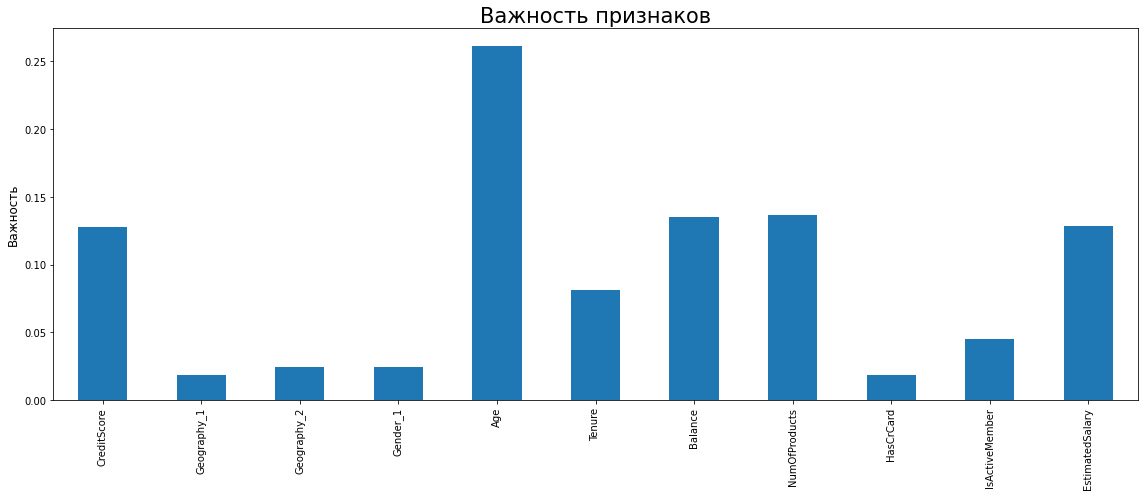

In [ ]:
feature_importances = pd.Series(model.feature_importances_, features_upsampled.columns)
fig, ax = plt.subplots(figsize=(16,7))
feature_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков", size = 21)
ax.set_ylabel('Важность', size = 12)
fig.tight_layout()

Больше всего на прогноз влияет возраст, а также кредитный рейтинг, баланс, количество используемых продуктов и предполагаемая зарплата. Меньше всего - география, гендер и наличие кредитной карты.

## Проверка модели на адекватность

Используем простой **Dummy-классификатор** для проверки итоговой модели на адекватность:

In [ ]:
# возьмем константную модель, которая для всех случаев прогнозирует класс "1"

dc = DummyClassifier(strategy='constant', constant = 1)
dc.fit(features_train, target_train)
predicted_test = dc.predict(features_test)
dc_test_result = f1_score(target_test, predicted_test)

print("F1-score DummyClassifier на тестовой выборке:", dc_test_result)

F1-score DummyClassifier на тестовой выборке: 0.3491539413949649


Модель проходит проверку на адекватность, значение f1-метрики константной модели меньше почти в 2 раза.

## Итоговый вывод

Для исследования нам были предоставлены данные о поведении клиентов и расторжении договоров с банком. Наша задача заключалась в том, чтобы построить модель, предсказывающую, уйдет клиент из банка в ближайшее время или нет.

На этапе предобработки данных мы обработали пропуски в столбце `Tenure` (сколько лет человек является клиентом банка) с помощью Sklearn KNNImputer. Также мы привели данные к одному масштабу и перевели категориальные признаки в численные с помощью техники OHE.

При подготовке признаков мы столкнулись с проблемой дисбаланса классов целевого признака - соотношение составляло 80/20 (20% клиентов расторгло договор с банком, а 80% соответственно осталось). Среди методов борьбы с дисбалансов лучше всего себя показал upsampling обучающей выборки (увеличение класса "1" в 4 раза).

По результатам исследования для решения задачи классификации клиентов банка была выбрана модель случайного леса, обученная на изменненой с помощью upsampling выборке. Модель прошла проверку на адекватность, **значение f1-метрики на тестовой выборке превысило пороговое и составило 0.6.**